In [197]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings    # 경고메시지 제외
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
warnings.filterwarnings(action='ignore')

plt.rc('font', family='NanumGothic')
sns.set(font="NanumGothic",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

df = pd.read_csv('./final_dataset.csv')

In [200]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

In [201]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,20))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

In [16]:
df.head()

,Unnamed: 0,idx,date,year,hour,spend_time,original_time,서울기온(°C),서울강수량(mm),서울풍속(m/s),...,부산풍속(m/s),부산습도(%),부산이슬점온도(°C),부산일조(hr),부산일사(MJ/m2),부산시정(10m),부산지면온도(°C),traffic_mean,is_weekend,is_covid
0,0,0,-3,2017,0,274.4,2017-10-01 00:00:00,18.4,0.0,1.3,...,1.1,60,10.6,0.0,0.0,2000,15.5,73,0,0
1,1,1,-3,2017,1,260.1,2017-10-01 01:00:00,18.0,0.0,1.6,...,2.1,44,5.6,0.0,0.0,2000,14.7,73,0,0
2,2,2,-3,2017,2,269.2,2017-10-01 02:00:00,17.9,0.0,1.8,...,1.3,56,8.8,0.0,0.0,2000,14.2,73,0,0
3,3,3,-3,2017,3,263.7,2017-10-01 03:00:00,17.7,0.0,1.8,...,0.7,51,7.1,0.0,0.0,2000,13.7,73,0,0
4,4,4,-3,2017,4,264.0,2017-10-01 04:00:00,17.5,0.0,1.3,...,0.9,54,7.4,0.0,0.0,1865,14.3,73,0,0


In [17]:
df.columns

Index(['Unnamed: 0', 'idx', 'date', 'year', 'hour', 'spend_time',
       'original_time', '서울기온(°C)', '서울강수량(mm)', '서울풍속(m/s)', '서울습도(%)',
       '서울이슬점온도(°C)', '서울일조(hr)', '서울일사(MJ/m2)', '서울시정(10m)', '서울지면온도(°C)',
       '부산기온(°C)', '부산강수량(mm)', '부산풍속(m/s)', '부산습도(%)', '부산이슬점온도(°C)',
       '부산일조(hr)', '부산일사(MJ/m2)', '부산시정(10m)', '부산지면온도(°C)', 'traffic_mean',
       'is_weekend', 'is_covid'],
      dtype='object')

In [202]:
# 필요없는 column 제거
df.drop(columns=['Unnamed: 0', 'idx', 'year'], inplace=True, axis=1)
# 범주형 데이터 처리
df_d = pd.get_dummies(df, columns=['date', 'hour'])

In [174]:
df_d.columns

Index(['spend_time', 'original_time', '서울기온(°C)', '서울강수량(mm)', '서울풍속(m/s)',
       '서울습도(%)', '서울이슬점온도(°C)', '서울일조(hr)', '서울일사(MJ/m2)', '서울시정(10m)',
       '서울지면온도(°C)', '부산기온(°C)', '부산강수량(mm)', '부산풍속(m/s)', '부산습도(%)',
       '부산이슬점온도(°C)', '부산일조(hr)', '부산일사(MJ/m2)', '부산시정(10m)', '부산지면온도(°C)',
       'traffic_mean', 'is_weekend', 'is_covid', 'date_-3', 'date_-2',
       'date_-1', 'date_0', 'date_1', 'date_2', 'date_3', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [203]:
time_index_df = df.set_index('original_time')

## 이변량 분석

In [204]:
hour_data = df.groupby('hour', as_index=False).agg({'spend_time':'mean', '서울기온(°C)':'mean', '서울강수량(mm)':'mean', '부산기온(°C)':'mean', '부산강수량(mm)':'mean'})
hour_data.head()

,hour,spend_time,서울기온(°C),서울강수량(mm),부산기온(°C),부산강수량(mm)
0,0,280.257857,19.022857,0.805714,20.162857,0.105714
1,1,279.501429,18.617143,0.334286,20.034286,0.180000
2,2,276.381429,18.291429,0.385714,19.891429,0.134286
3,3,275.407857,17.951429,0.197143,19.800000,0.128571
4,4,275.157143,17.694286,0.420000,19.625714,0.531429


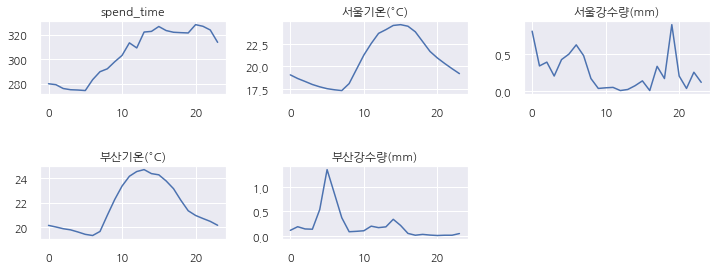

In [205]:
plt.figure(figsize=(12, 4))

plt.subplots_adjust(hspace=1, wspace=0.3)
plt.subplot(2, 3, 1)
plt.plot(hour_data['hour'], hour_data['spend_time'])
plt.title('spend_time')
plt.subplot(2, 3, 2)
plt.plot(hour_data['hour'], hour_data['서울기온(°C)'])
plt.title('서울기온(°C)')
plt.subplot(2, 3, 3)
plt.plot(hour_data['hour'], hour_data['서울강수량(mm)'])
plt.title('서울강수량(mm)')
plt.subplot(2, 3, 4)
plt.plot(hour_data['hour'], hour_data['부산기온(°C)'])
plt.title('부산기온(°C)')
plt.subplot(2, 3, 5)
plt.plot(hour_data['hour'], hour_data['부산강수량(mm)'])
plt.title('부산강수량(mm)')

plt.show()

<AxesSubplot:>

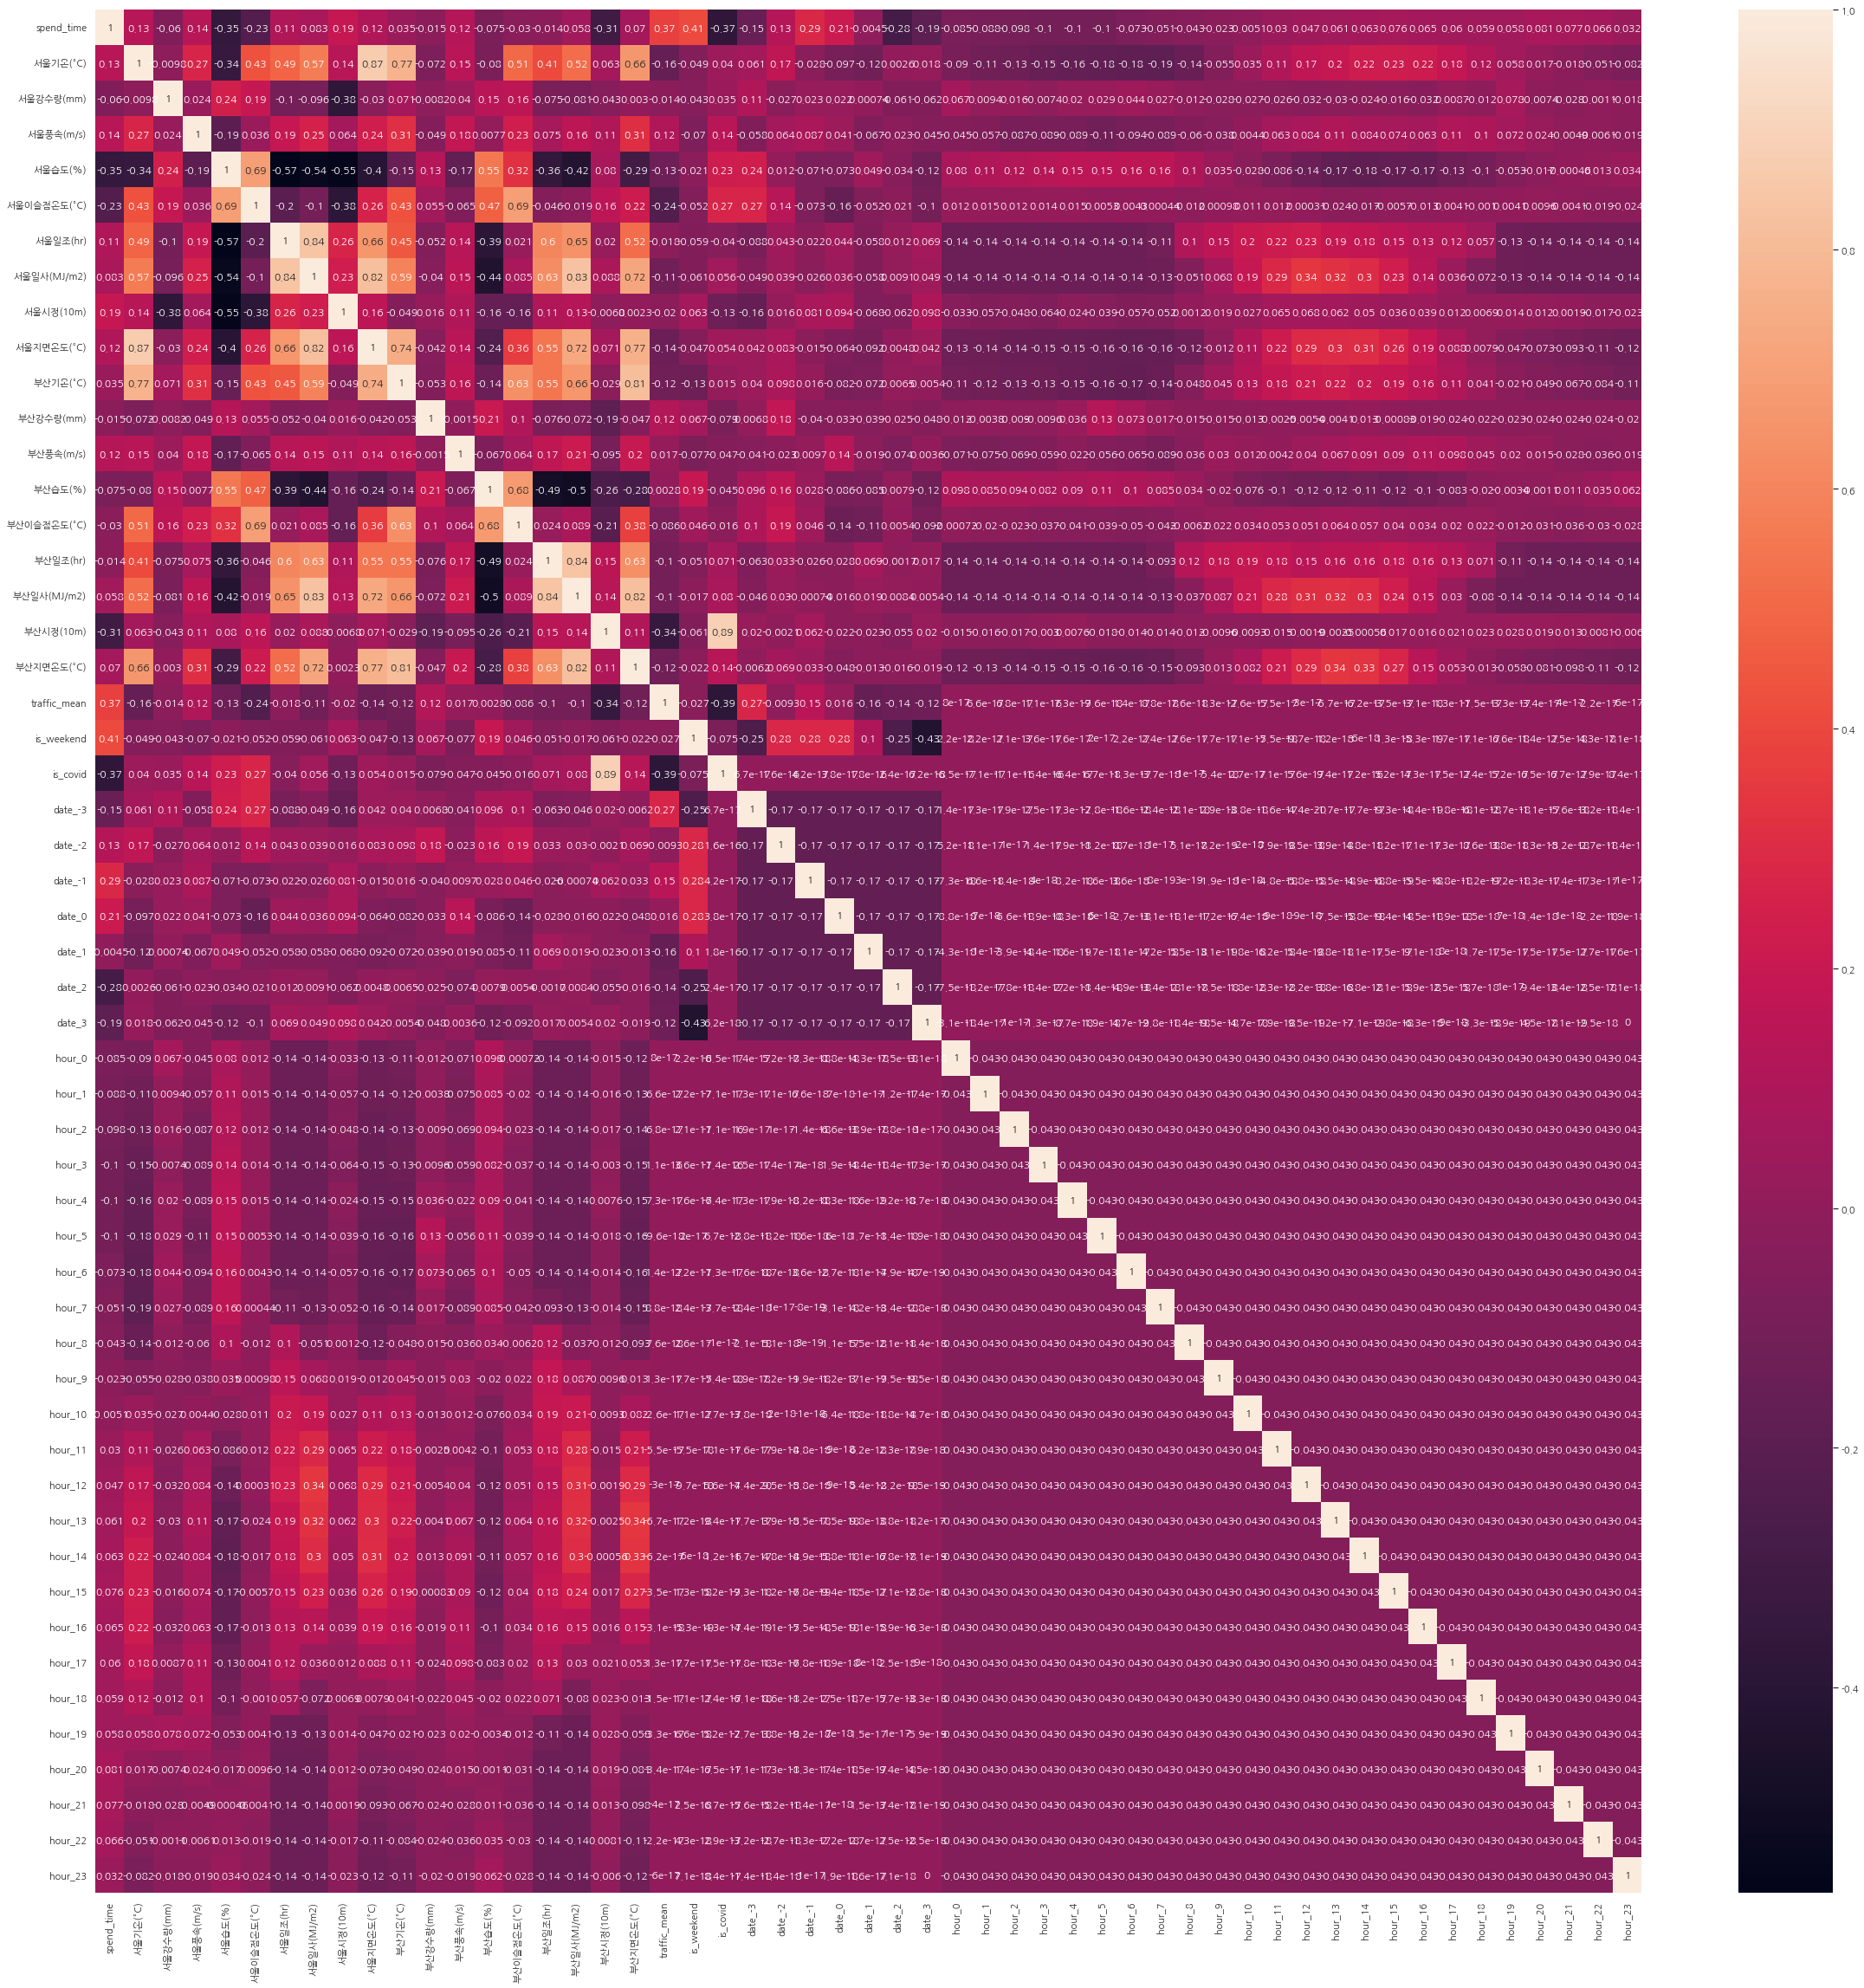

In [36]:
plt.figure(figsize=(40, 40))
sns.heatmap(df_d.corr(), annot=True)

<AxesSubplot:ylabel='spend_time'>

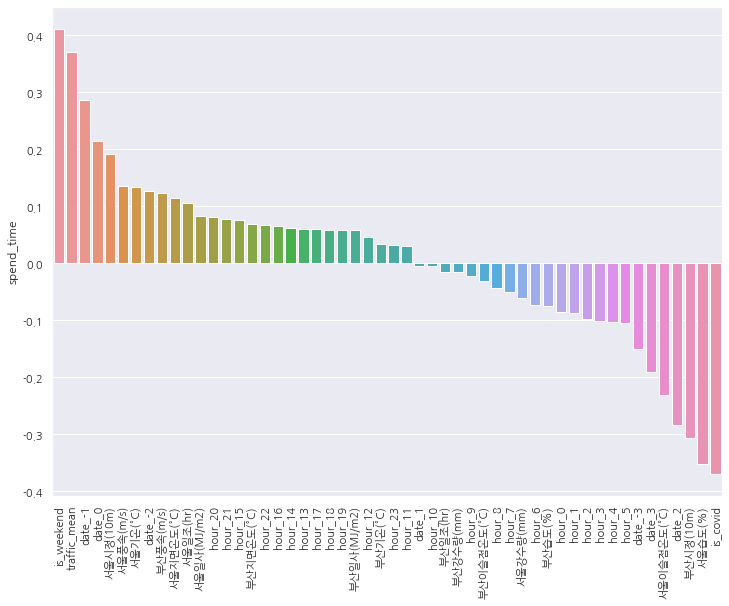

In [39]:
plt.figure(figsize=(12,9)) # 사이즈 변경
plt.xticks(rotation = 90) # x축 text 회전
sns.barplot(x = (df_d.corr()["spend_time"]).sort_values(ascending = False)[1:].index ,
            y = (df_d.corr()["spend_time"]).sort_values(ascending = False)[1:]) # spend_time을 제외하고 나머지와의 상관관계 시각화

<AxesSubplot:ylabel='spend_time'>

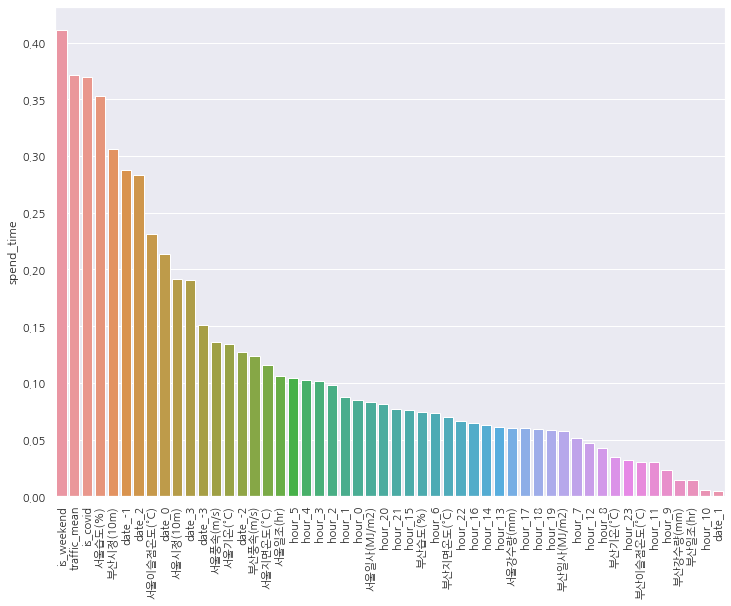

In [40]:
plt.figure(figsize=(12,9)) # 사이즈 변경
plt.xticks(rotation = 90) # x축 text 회전
sns.barplot(x = abs(df_d.corr()["spend_time"]).sort_values(ascending = False)[1:].index ,
            y = abs(df_d.corr()["spend_time"]).sort_values(ascending = False)[1:]) # spend_time을 제외하고 나머지와의 상관관계 시각화

보이는가? 새롭게 만든 3개가 높은 상관관계가 있었다.  
- 서울습도가 높으면 또한 spend_time이 높은 음의 상관계수를 가졌는데 이는 비가 오거나 안개가 낄 확률이 높아져 그런 것이라고 생각했다.  
- 이는 시정과 관련있다고 생각한다. 안개 때문에 말이다..
- 날짜관련해서도 어느정도 상관관계가 있었다.
- 시간으로는 새벽시간에 높게 나타났다.  

*새로만든 애들에 대해서 검증해보자*

In [206]:
import scipy.stats as spst

#### is_weekend (범주형)

In [31]:
spst.ttest_ind(time_index_df['is_weekend'], time_index_df['spend_time'])

Ttest_indResult(statistic=-146.29817549395165, pvalue=0.0)

#### traffic_mean (수치형)

In [34]:
print(spst.pearsonr(time_index_df['traffic_mean'], time_index_df['spend_time']))

(0.3709603831627283, 8.456594592130245e-29)


#### is_covid (범주형)

In [35]:
spst.ttest_ind(time_index_df['is_covid'], time_index_df['spend_time'])

Ttest_indResult(statistic=-146.43513496013674, pvalue=0.0)

In [178]:
df_d_time_df = df_d.copy()

In [ ]:
df_d_time_df['DT'] = df_d_time_df['original_time']
df_d_time_df.set_index('DT', inplace=True)

In [208]:
temp = df_d_time_df.asfreq('H')
df_d_time_df['y'] = df_d_time_df['spend_time'].shift(-1)
df_d_time_df = df_d_time_df[:-1]

In [217]:
df = pd.read_csv('./real_final.csv')

In [220]:
df = df.set_index('DT')

In [ ]:
target='y'
x = df.drop([target, 'original_time'], axis=1)
y = df.loc[:, target]



x_train = x[:671]
y_train = y[:671]
x_test = x[672:839]
y_test = y[672:839]
x_pred = x[840]
y_pred = y[840]

x_train.to_csv('./split/next_x_train.csv')
y_train.to_csv('./split/next_y_train.csv')
x_test.to_csv('./split/next_x_test.csv')
y_test.to_csv('./split/next_y_test.csv')

In [210]:
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [211]:
df_d_time_df.to_csv('./temp.csv')

In [189]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import * 

lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)

print('RMSE : ', round(mean_squared_error(y_test, lr_pred, squared=False), 5))
print('MAE  : ', round(mean_absolute_error(y_test, lr_pred), 5))
print('MAPE : ', round(mean_absolute_percentage_error(y_test, lr_pred), 5))
print("r2_score 점수 : {:.3f}".format(r2_score(y_test,lr_pred)))

RMSE :  16.62049
MAE  :  12.09147
MAPE :  0.04267
r2_score 점수 : 0.825


In [190]:
def prediction_plot(pred_model):
  plt.figure(figsize = (20,8))
  plt.plot(y_test, label = 'val')
  plt.plot(pred_model, label = 'pred')

  plt.legend()
  plt.grid()
  plt.show()

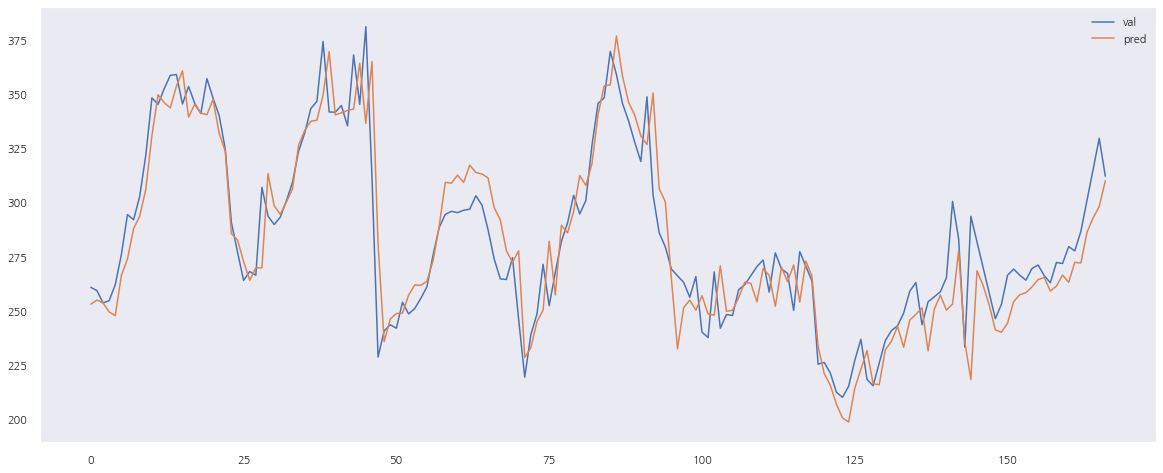

In [191]:
prediction_plot(lr_pred)

In [78]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)

print('RMSE : ', round(mean_squared_error(y_test, rf_pred, squared=False), 5))
print('MAE  : ', round(mean_absolute_error(y_test, rf_pred), 5))
print('MAPE : ', round(mean_absolute_percentage_error(y_test, rf_pred), 5))
print("r2_score 점수 : {:.3f}".format(r2_score(y_test, rf_pred)))

RMSE :  17.11836
MAE  :  11.88993
MAPE :  0.04279
r2_score 점수 : 0.815


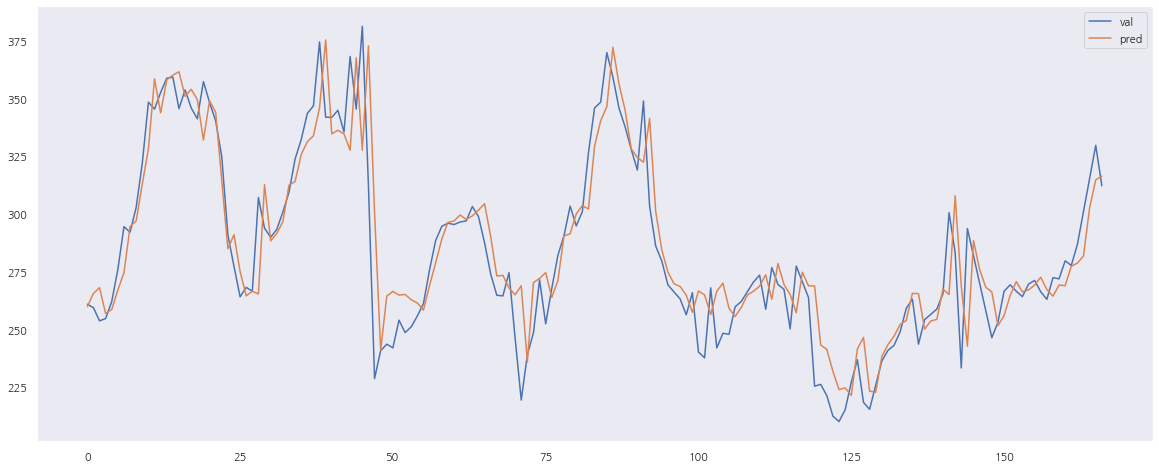

In [80]:
prediction_plot(rf_pred)

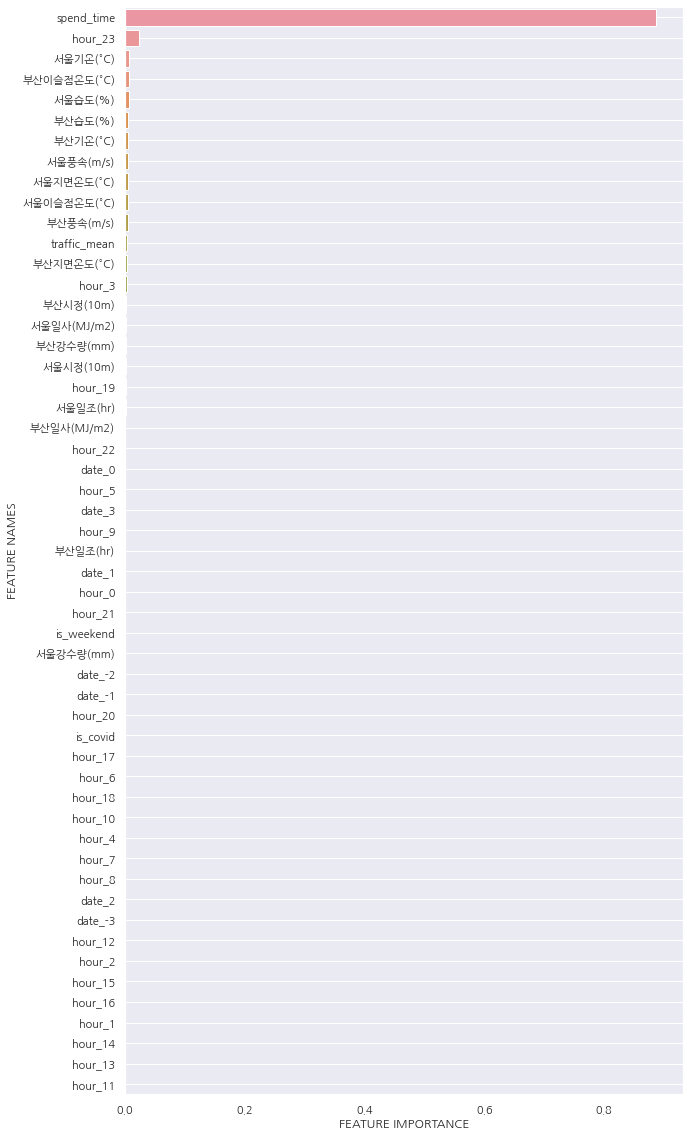

In [103]:
result = plot_feature_importance(rf_model.feature_importances_, list(x_train))

In [ ]:
from sklearn.model_selection import GridSearchCV
params = { 'n_estimators' : [10, 100, 1000],
           'max_depth' : [2, 4, 6],
           'min_samples_leaf' : [2, 4, 6],
           'min_samples_split' : [2, 4, 6, 8]
            }

In [105]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(x_train, y_train)

grb_pred = gbr_model.predict(x_test)

print('RMSE : ', round(mean_squared_error(y_test, grb_pred, squared=False), 5))
print('MAE  : ', round(mean_absolute_error(y_test, grb_pred), 5))
print('MAPE : ', round(mean_absolute_percentage_error(y_test, grb_pred), 5))
print("r2_score 점수 : {:.3f}".format(r2_score(y_test, grb_pred)))

RMSE :  20.27887
MAE  :  14.47614
MAPE :  0.05133
r2_score 점수 : 0.740


In [107]:
import xgboost
xgb_model = xgboost.XGBRegressor()
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)

print('RMSE : ', round(mean_squared_error(y_test, xgb_pred, squared=False), 5))
print('MAE  : ', round(mean_absolute_error(y_test, xgb_pred), 5))
print('MAPE : ', round(mean_absolute_percentage_error(y_test, xgb_pred), 5))
print("r2_score 점수 : {:.3f}".format(r2_score(y_test, xgb_pred)))

RMSE :  20.08499
MAE  :  14.55118
MAPE :  0.05237
r2_score 점수 : 0.745


In [112]:
# from sklearn.linear_model import Lasso
# l1_model = Lasso()
# l1_model.fit(x_train, y_train)
# l1_pred = l1_model.predict(x_test)

# print('RMSE : ', round(mean_squared_error(y_test, l1_pred, squared=False), 5))
# print('MAE  : ', round(mean_absolute_error(y_test, l1_pred), 5))
# print('MAPE : ', round(mean_absolute_percentage_error(y_test, l1_pred), 5))
# print("r2_score 점수 : {:.3f}".format(r2_score(y_test, l1_pred)))

RMSE :  16.31602
MAE  :  11.3617
MAPE :  0.0403
r2_score 점수 : 0.832


In [116]:
from sklearn.linear_model import Lasso
l1_model_2 = Lasso(alpha=0.1, )
l1_model_2.fit(x_train, y_train)
l1_pred_2 = l1_model_2.predict(x_test)

print('RMSE : ', round(mean_squared_error(y_test, l1_pred_2, squared=False), 5))
print('MAE  : ', round(mean_absolute_error(y_test, l1_pred_2), 5))
print('MAPE : ', round(mean_absolute_percentage_error(y_test, l1_pred_2), 5))
print("r2_score 점수 : {:.3f}".format(r2_score(y_test, l1_pred_2)))

RMSE :  15.75572
MAE  :  11.10735
MAPE :  0.03895
r2_score 점수 : 0.843


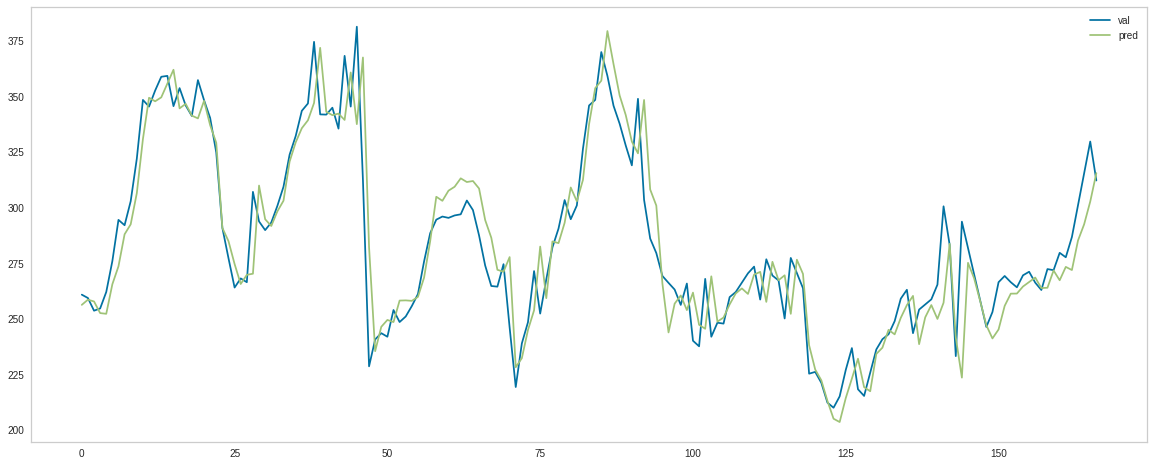

In [122]:
prediction_plot(l1_pred_2)

In [111]:
# from sklearn.linear_model import Ridge
# l2_model = Ridge().fit(x_train, y_train)
# l2_model.fit(x_train, y_train)
# l1_pred = l2_model.predict(x_test)

# print('RMSE : ', round(mean_squared_error(y_test, l1_pred, squared=False), 5))
# print('MAE  : ', round(mean_absolute_error(y_test, l1_pred), 5))
# print('MAPE : ', round(mean_absolute_percentage_error(y_test, l1_pred), 5))
# print("r2_score 점수 : {:.3f}".format(r2_score(y_test, l1_pred)))

RMSE :  16.55902
MAE  :  12.00047
MAPE :  0.04234
r2_score 점수 : 0.827


In [121]:
# from sklearn.linear_model import ElasticNet
# e_model = ElasticNet(alpha=0.1, l1_ratio=0.7)
# e_model.fit(x_train, y_train)
# e_pred = e_model.predict(x_test)

# print('RMSE : ', round(mean_squared_error(y_test, e_pred, squared=False), 5))
# print('MAE  : ', round(mean_absolute_error(y_test, e_pred), 5))
# print('MAPE : ', round(mean_absolute_percentage_error(y_test, e_pred), 5))
# print("r2_score 점수 : {:.3f}".format(r2_score(y_test, e_pred)))

RMSE :  16.01528
MAE  :  11.27982
MAPE :  0.03975
r2_score 점수 : 0.838


In [127]:
df.head(1)

,Unnamed: 0,idx,date,year,hour,spend_time,original_time,서울기온(°C),서울강수량(mm),서울풍속(m/s),서울습도(%),서울이슬점온도(°C),서울일조(hr),서울일사(MJ/m2),서울시정(10m),서울지면온도(°C),부산기온(°C),부산강수량(mm),부산풍속(m/s),부산습도(%),부산이슬점온도(°C),부산일조(hr),부산일사(MJ/m2),부산시정(10m),부산지면온도(°C),traffic_mean,is_weekend,is_covid
0,0,0,-3,2017,0,274.4,2017-10-01 00:00:00,18.4,0.0,1.3,83,15.4,0.0,0.0,513,15.1,18.6,0.0,1.1,60,10.6,0.0,0.0,2000,15.5,73,0,0


In [124]:
df.columns

Index(['Unnamed: 0', 'idx', 'date', 'year', 'hour', 'spend_time',
       'original_time', '서울기온(°C)', '서울강수량(mm)', '서울풍속(m/s)', '서울습도(%)',
       '서울이슬점온도(°C)', '서울일조(hr)', '서울일사(MJ/m2)', '서울시정(10m)', '서울지면온도(°C)',
       '부산기온(°C)', '부산강수량(mm)', '부산풍속(m/s)', '부산습도(%)', '부산이슬점온도(°C)',
       '부산일조(hr)', '부산일사(MJ/m2)', '부산시정(10m)', '부산지면온도(°C)', 'traffic_mean',
       'is_weekend', 'is_covid'],
      dtype='object')

In [136]:
df['부산시정(10m)'].mean()

2893.8142857142857

이슬점 온도는 아래 링크에서 수식계산   
https://makerjeju.tistory.com/24   
https://www.weather.go.kr/w/obs-climate/land/city-obs.do?auto_man=m&stn=0&dtm=12&type=t99&reg=109&tm=2022.09.08.17%3A00

작년보다 평균 이동량 10%가 증가할 전망

In [163]:
df.loc[840] = ['840', '840', '0', '2022', '12', '0.0', '2022-09-10 12:00:00', '26', '0.0', '2', '45', '13.2', '0.3', '1.23', '2000', '31.2', '26', '0', '8', '65', '18.9', '0.0', '0.12', '4000', '30.5', '12.2', '1', '1']

In [171]:
df

,Unnamed: 0,idx,date,year,hour,spend_time,original_time,서울기온(°C),서울강수량(mm),서울풍속(m/s),서울습도(%),서울이슬점온도(°C),서울일조(hr),서울일사(MJ/m2),서울시정(10m),서울지면온도(°C),부산기온(°C),부산강수량(mm),부산풍속(m/s),부산습도(%),부산이슬점온도(°C),부산일조(hr),부산일사(MJ/m2),부산시정(10m),부산지면온도(°C),traffic_mean,is_weekend,is_covid
0,0,0,-3,2017,0,274.4,2017-10-01 00:00:00,18.4,0.0,1.3,83,15.4,0.0,0.00,513,15.1,18.6,0.0,1.1,60,10,0.0,0.00,2000,15.5,73,0,0
1,1,1,-3,2017,1,260.1,2017-10-01 01:00:00,18.0,0.0,1.6,81,14.6,0.0,0.00,582,15.2,18.1,0.0,2.1,44,5,0.0,0.00,2000,14.7,73,0,0
2,2,2,-3,2017,2,269.2,2017-10-01 02:00:00,17.9,0.0,1.8,81,14.5,0.0,0.00,561,15.5,17.8,0.0,1.3,56,8,0.0,0.00,2000,14.2,73,0,0
3,3,3,-3,2017,3,263.7,2017-10-01 03:00:00,17.7,0.0,1.8,80,14.1,0.0,0.00,532,15.2,17.4,0.0,0.7,51,7,0.0,0.00,2000,13.7,73,0,0
4,4,4,-3,2017,4,264.0,2017-10-01 04:00:00,17.5,0.0,1.3,79,13.8,0.0,0.00,604,15.4,16.8,0.0,0.9,54,7,0.0,0.00,1865,14.3,73,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,836,836,3,2021,20,301.1,2021-09-24 20:00:00,23.3,0.0,3.1,63,15.8,0.0,0.00,2000,20.7,20.9,0.0,3.6,79,17,0.0,0.00,5000,20.5,21,0,1
837,837,837,3,2021,21,315.4,2021-09-24 21:00:00,22.4,0.0,3.0,66,15.7,0.0,0.00,2000,20.1,20.4,0.0,2.8,77,16,0.0,0.00,5000,19.8,21,0,1
838,838,838,3,2021,22,329.7,2021-09-24 22:00:00,21.6,0.0,3.8,69,15.6,0.0,0.00,2000,19.6,20.2,0.0,3.2,79,16,0.0,0.00,5000,19.5,21,0,1
839,839,839,3,2021,23,312.2,2021-09-24 23:00:00,20.9,0.0,3.3,70,15.2,0.0,0.00,2000,19.2,20.1,0.0,2.5,81,16,0.0,0.00,5000,19.4,21,0,1


In [ ]:
float_list = ['spend_time', '서울기온(°C)', 
              '서울강수량(mm)', '서울풍속(m/s)',  '서울이슬점온도(°C)', '서울일조(hr)',
              '서울일사(MJ/m2)', '서울지면온도(°C)', '부산기온(°C)', '부산강수량(mm)',
              '부산풍속(m/s)', '부산일조(hr)', '부산일사(MJ/m2)', '부산지면온도(°C)']
int_list = ['Unnamed: 0', 'idx', 'year', 'hour','서울습도(%)',  '서울시정(10m)', '부산습도(%)',
             '부산이슬점온도(°C)','부산시정(10m)', 'traffic_mean', 'is_weekend', 'is_covid']
df[float_list] = df[float_list].astype(np.float64)
df[int_list] = df[int_list].astype(np.int64)

In [165]:
df

,Unnamed: 0,idx,date,year,hour,spend_time,original_time,서울기온(°C),서울강수량(mm),서울풍속(m/s),서울습도(%),서울이슬점온도(°C),서울일조(hr),서울일사(MJ/m2),서울시정(10m),서울지면온도(°C),부산기온(°C),부산강수량(mm),부산풍속(m/s),부산습도(%),부산이슬점온도(°C),부산일조(hr),부산일사(MJ/m2),부산시정(10m),부산지면온도(°C),traffic_mean,is_weekend,is_covid
0,0,0,-3,2017,0,274.4,2017-10-01 00:00:00,18.4,0.0,1.3,83,15.4,0.0,0.00,513,15.1,18.6,0.0,1.1,60,10,0.0,0.00,2000,15.5,73,0,0
1,1,1,-3,2017,1,260.1,2017-10-01 01:00:00,18.0,0.0,1.6,81,14.6,0.0,0.00,582,15.2,18.1,0.0,2.1,44,5,0.0,0.00,2000,14.7,73,0,0
2,2,2,-3,2017,2,269.2,2017-10-01 02:00:00,17.9,0.0,1.8,81,14.5,0.0,0.00,561,15.5,17.8,0.0,1.3,56,8,0.0,0.00,2000,14.2,73,0,0
3,3,3,-3,2017,3,263.7,2017-10-01 03:00:00,17.7,0.0,1.8,80,14.1,0.0,0.00,532,15.2,17.4,0.0,0.7,51,7,0.0,0.00,2000,13.7,73,0,0
4,4,4,-3,2017,4,264.0,2017-10-01 04:00:00,17.5,0.0,1.3,79,13.8,0.0,0.00,604,15.4,16.8,0.0,0.9,54,7,0.0,0.00,1865,14.3,73,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,836,836,3,2021,20,301.1,2021-09-24 20:00:00,23.3,0.0,3.1,63,15.8,0.0,0.00,2000,20.7,20.9,0.0,3.6,79,17,0.0,0.00,5000,20.5,21,0,1
837,837,837,3,2021,21,315.4,2021-09-24 21:00:00,22.4,0.0,3.0,66,15.7,0.0,0.00,2000,20.1,20.4,0.0,2.8,77,16,0.0,0.00,5000,19.8,21,0,1
838,838,838,3,2021,22,329.7,2021-09-24 22:00:00,21.6,0.0,3.8,69,15.6,0.0,0.00,2000,19.6,20.2,0.0,3.2,79,16,0.0,0.00,5000,19.5,21,0,1
839,839,839,3,2021,23,312.2,2021-09-24 23:00:00,20.9,0.0,3.3,70,15.2,0.0,0.00,2000,19.2,20.1,0.0,2.5,81,16,0.0,0.00,5000,19.4,21,0,1
